In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 加载模型
model = torch.load('torch_alex.pth')
model.eval()

# 图像处理函数
def process_image(image_path):
    # 图像预处理
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess(image).unsqueeze(0)
    return image

# 获取最后一个卷积层
def get_last_conv_layer(model):
    for layer in reversed(model.features):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    raise Exception("No convolutional layer found in the model")

# 可视化最后一层卷积层的特征图
def visualize_feature_maps(model, input_tensor):
    last_conv_layer = get_last_conv_layer(model)
    
    # 创建一个钩子来获取特征图
    activations = None
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output

    hook = last_conv_layer.register_forward_hook(hook_fn)

    # 前向传播获取特征图
    model(input_tensor)

    # 注销钩子
    hook.remove()

    # 绘制特征图
    num_features = activations.shape[1]
    fig, axes = plt.subplots(1, num_features, figsize=(20, 20))
    for i in range(num_features):
        ax = axes[i]
        ax.imshow(activations[0, i].cpu().detach().numpy(), cmap='viridis')
        ax.axis('off')
    plt.show()

# 图像路径
image_paths = ['data4/both.jpg', 'data4/cat.jpg', 'data4/dog.jpg']

# 处理并可视化每张图像的特征图
for image_path in image_paths:
    input_tensor = process_image(image_path)
    visualize_feature_maps(model, input_tensor)

c:\Users\19012\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


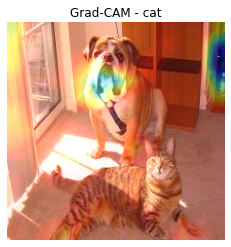

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


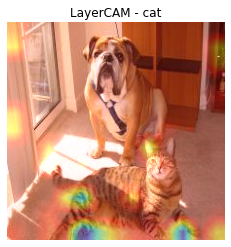

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


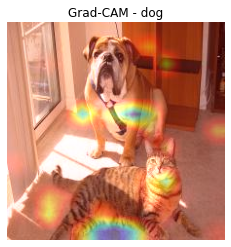

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


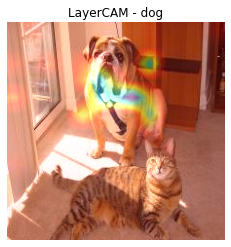

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


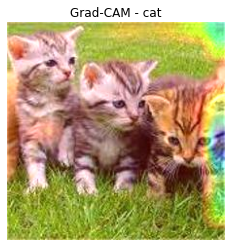

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


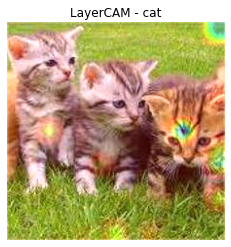

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


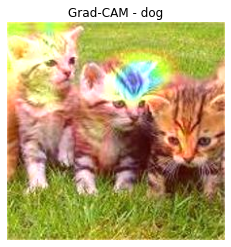

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


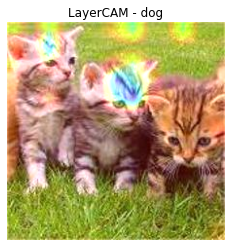

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


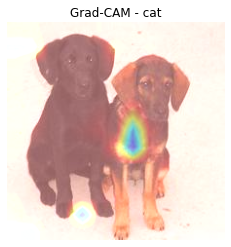

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


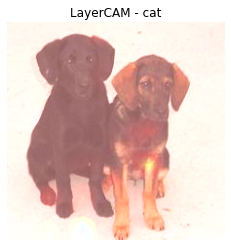

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


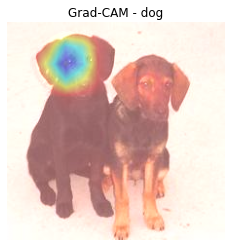

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


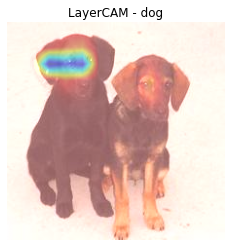

In [2]:
import torch.nn.functional as F

class_indices = {'cat': 0, 'dog': 1}

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx):
        model_output = self.model(input_tensor)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output).scatter_(1, class_idx.unsqueeze(-1), 1.0)
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(pooled_gradients.size()[0]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap

class LayerCAM(GradCAM):
    def generate_heatmap(self, input_tensor, class_idx):
        model_output = self.model(input_tensor)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output).scatter_(1, class_idx.unsqueeze(-1), 1.0)
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        guided_gradients = self.activations * self.gradients
        heatmap = torch.mean(guided_gradients, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap

# 获取最后一个卷积层
def get_last_conv_layer(model):
    conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
    if conv_layers:
        return conv_layers[-1]  # 返回列表中的最后一个卷积层
    else:
        raise Exception("No convolutional layer found in the model")

# 应用 Grad-CAM 和 LayerCAM
def apply_cam_methods(model, input_tensor, class_idx):
    last_conv_layer = get_last_conv_layer(model)
    grad_cam = GradCAM(model, last_conv_layer)
    layer_cam = LayerCAM(model, last_conv_layer)

    # 生成热图并立即从计算图中分离
    grad_cam_heatmap = grad_cam.generate_heatmap(input_tensor, class_idx).detach().numpy()
    layer_cam_heatmap = layer_cam.generate_heatmap(input_tensor, class_idx).detach().numpy()

    return grad_cam_heatmap, layer_cam_heatmap

# 显示热图
def display_heatmap(image, heatmap, title):
    # 将热图放大到与原始图像相同的尺寸
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    # 将热图转换为颜色图像
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # 叠加热图和原始图像
    superimposed_img = heatmap * 0.4 + image
    plt.imshow(superimposed_img / 255)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 应用 CAM 方法并显示热图
for image_path in image_paths:
    input_tensor = process_image(image_path)
    
    for class_name in ['cat', 'dog']:
        class_idx = torch.tensor([class_indices[class_name]])  # 对 'cat' 和 'dog' 类别进行处理

        grad_cam_heatmap, layer_cam_heatmap = apply_cam_methods(model, input_tensor, class_idx)

        # 可视化原始图像和热图
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        original_image = cv2.resize(original_image, (224, 224))

        display_heatmap(original_image, grad_cam_heatmap, f"Grad-CAM - {class_name}")
        display_heatmap(original_image, layer_cam_heatmap, f"LayerCAM - {class_name}")